In [96]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K


seed = 7
tf.random.set_seed(seed)

In [2]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)    
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [4]:
def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        
        encoder.fit(x_test)
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(encode):
    train = pd.read_csv("../data/ML-CUP22-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.head()
    y_train = train.iloc[:, :2].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 2:].to_numpy().astype(np.float64)
    x_test = test.to_numpy().astype(np.float64)
    return x_train, y_train, x_test, None
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [114]:
def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged



def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    # keys.remove("max_epochs")
    keys.remove("initialization")
    keys.remove("early_stopping")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        
        configurations.append(dict_conf)
        
    return configurations



def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_model(config, input_size):    
    lr = config["learning_rate"]
    reg = config["regularizer"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
    
    init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    
    activation = config["activations_1"]
    n_units = config["units_1"]
    model.add(Dense(n_units, input_dim=input_size, activation=activation, kernel_regularizer=l2(reg),
                    bias_regularizer=l2(reg), kernel_initializer = init, bias_initializer = init))
    
    for l in range(2,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        model.add(Dense(n_units, activation=activation, kernel_regularizer=l2(reg),
                        bias_regularizer=l2(reg), kernel_initializer = init, bias_initializer = init))
        
        
    model.add(Dense(1, activation="sigmoid", kernel_regularizer=l2(reg),
                    bias_regularizer=l2(reg), kernel_initializer = init, bias_initializer = init))
    
    optimizer = SGD(learning_rate=lr, momentum=momentum)
    
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"], 
        min_delta=early_stopping["delta"], 
    )
    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for train_index, val_index in kf.split(x_train, y_train):
        
        model = get_model(config, x_train.shape[1])
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                            validation_data=(x_val_fold, y_val_fold),
                            callbacks=[early_stop], verbose = 0)

        train_loss = history.history["loss"]
        train_acc = history.history["accuracy"]
        val_loss = history.history["val_loss"]
        val_acc = history.history["val_accuracy"]



        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)


    mean_train_loss = sum(train_losses[-1])/len(train_losses[-1])
    mean_train_acc = sum(train_accs[-1])/len(train_accs[-1])
    mean_val_loss = sum(val_losses[-1])/len(val_losses[-1])
    mean_valid_acc = sum(val_accs[-1])/len(val_accs[-1])

    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    model = get_model(config, x_train.shape[1])
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"], 
    )
    
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True)
    
    history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                        verbose=0, validation_data=(x_val, y_val), callbacks=[early_stop])
        
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]
    
    # plot_curves(train_acc, "Training accuracy", val_acc, "Validation accuracy")
    # plot_curves(train_loss, "Training loss", val_loss, "Validation loss")
    
    return val_loss[-1]
    
    
def fit_model_no_val(model, x_train, y_train, config):

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    
    if early_stopping["monitor"] == "val_loss":
        early_stopping["monitor"] = "loss"
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"], 
        min_delta=early_stopping["delta"], 
    )
        
    history = model.fit(x_train, y_train, epochs=max_epochs,
                        batch_size=batch_size, verbose=0, callbacks=[early_stop])
    
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    
    # plot_curves(train_acc, "Training accuracy")
    # plot_curves(train_loss, "Training loss")
    
    return history



    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)

    
    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    with tqdm(total=len(configurations)) as pbar:
        for config in configurations:
            print(config)
            val_loss = fit_model(x_train, y_train, config, validation)
            
            if val_loss < best_loss:
                best_loss = val_loss;
                best_conf = config
            
            pbar.update(1)
            
    print(best_loss)
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    configurations = get_configurations(params)
    best_conf = model_selection(configurations, x_train, y_train, validation)
    
    model = get_model(best_conf, x_train.shape[1])
    history = fit_model_no_val(model, x_train, y_train, best_conf)
    
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    
    plot_curves(train_acc, "Training accuracy")
    plot_curves(train_loss, "Training loss")
    
    return model

In [77]:
params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.9],
    "regularizer": [0.0001],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,2,3,4,5,6,7,7],
        },
    ]
}


"""params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": 500,
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [None],
    "momentum": [0.1, 0.9],
    "regularizer": [0, 0.1],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,4,8],
        },
    ]
}"""

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

# Monks 1

In [94]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'regularizer': 0.0001, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'loss', 'patience': 20, 'delta': 0.001}, 'activations_1': 'relu', 'units_1': 5}


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.56s/it]


0.07079689722564636


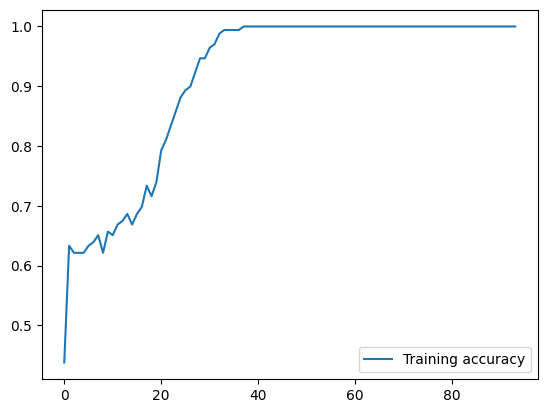

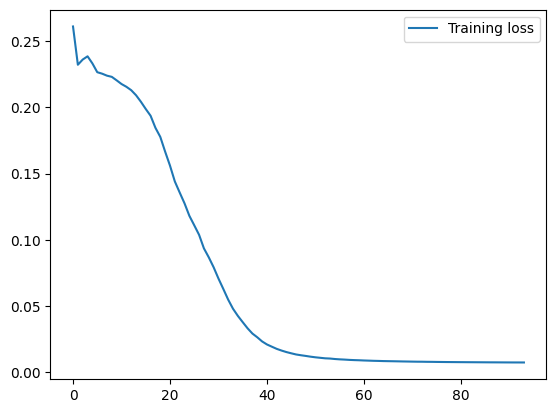

14/14 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 1.0000
[0.007795675657689571, 1.0]


In [119]:
model = grid_search(params, x_train, y_train, k_fold_val)
test_model(model, x_test, y_test)

# Monks 2

In [117]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'regularizer': 0.0001, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'loss', 'patience': 20, 'delta': 0.001}, 'activations_1': 'relu', 'units_1': 5}


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.64s/it]


0.07907025026448003


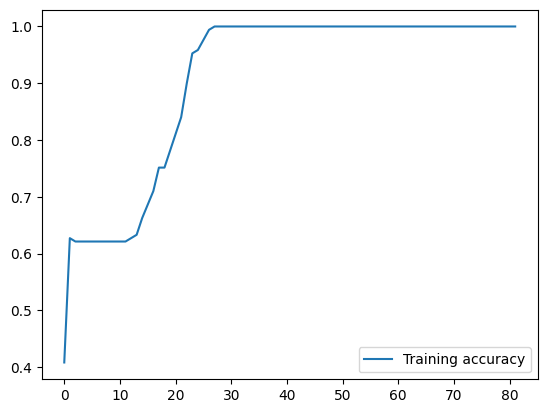

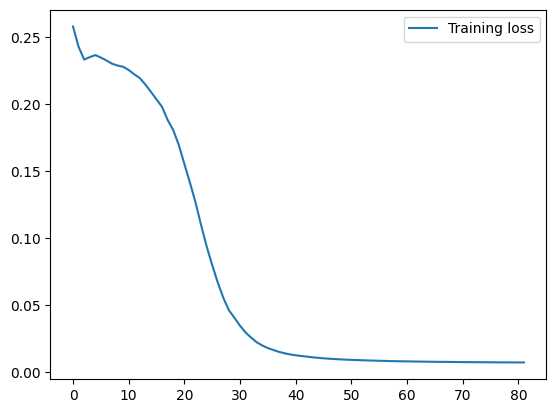

14/14 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 1.0000
[0.007607754785567522, 1.0]


In [120]:
model = grid_search(params, x_train, y_train, k_fold_val)
test_model(model, x_test, y_test)

# Monks 3

In [121]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'regularizer': 0.0001, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'loss', 'patience': 20, 'delta': 0.001}, 'activations_1': 'relu', 'units_1': 5}


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.05s/it]


0.10377909116877997


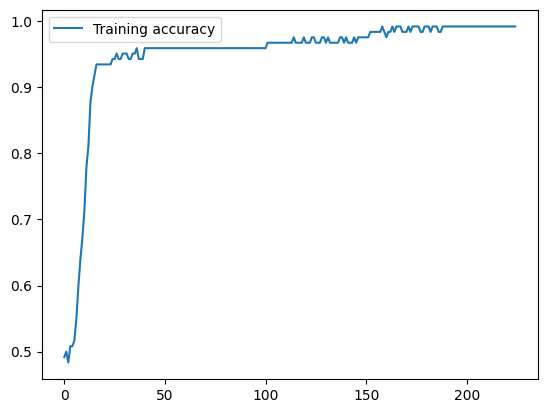

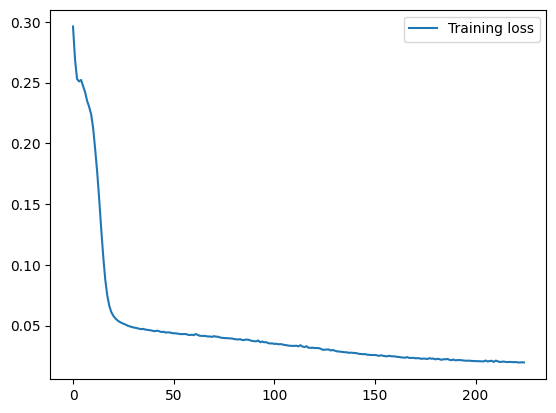

14/14 [==============================] - 0s 2ms/step - loss: 0.0412 - accuracy: 0.9560
[0.041197553277015686, 0.9560185074806213]


In [123]:
model = grid_search(params, x_train, y_train, k_fold_val)
test_model(model, x_test, y_test)